# Goal: To recognize the concentration of anomalies


**Sections in the notebook:**

1. Dependencies
2. Skewness check and Boxplot
3. Data Munging
4. Anomaly Density Plot
5. Interpretation and basic result validation

**About Data:**
1. A film product is being produced in a âroll to rollâ process (think saran wrap moving from one roll to another)
2. As it moves, its material qualities are measured by 62 sensors
3. Weâve applied anomaly detection to these values, to produce the dataset attached (this is a small sample, the whole thing comprises 310 sensors and millions of observations)
4. The values you see are anomaly scores output from our anomaly detection model: they range between 0 (normal) and 1 (maximally anomalous)

# Section 1: Dependencies

In [1]:
# Dependencies

install.packages('e1071')
library(e1071)
library(reshape2)
library(ggplot2)
suppressPackageStartupMessages(library(reshape, quietly=TRUE))
suppressPackageStartupMessages(library(dplyr, quietly=TRUE))
library("AzureML")

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)



The downloaded source packages are in
	'/tmp/RtmpADODw6/downloaded_packages'


In [2]:
ws <- workspace()
df <- download.datasets(ws, "ns.csv")
head(df)

X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,...,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87
0.1771543,0.06906965,0.08563347,0.1912293,0.11871234,0.1298178,0.09671620,0.1670924,0.1336682,0.12724304,...,0.0971420,0.1178328,0.1246967,0.09362106,0.1443217,0.1383350,0.06881743,0.2177545,0.1041465,0.1398979
0.1786019,0.07860830,0.08944544,0.1884205,0.12279996,0.1304170,0.09044257,0.1754386,0.1286396,0.16114967,...,0.1017358,0.1890643,0.1059831,0.10756652,0.1198029,0.1180805,0.07892904,0.2216623,0.1061694,0.1236331
0.1717280,0.06810865,0.11596354,0.1899335,0.09271166,0.1242013,0.08196107,0.1826624,0.1473473,0.12899083,...,0.1952935,0.1746590,0.1628295,0.09380606,0.1272781,0.1279830,0.08756382,0.2186955,0.1299912,0.1279981
0.1689855,0.06919595,0.09884667,0.1739181,0.08951671,0.1109827,0.11273974,0.2245411,0.1465943,0.12010988,...,0.1350308,0.1512911,0.1762825,0.10383350,0.1996499,0.1183830,0.05422748,0.1984536,0.1253444,0.1410195
0.1648037,0.07456567,0.07507974,0.1145188,0.07168554,0.1289210,0.10919430,0.2374430,0.1307677,0.09887215,...,0.1210983,0.1402600,0.1877743,0.11789544,0.1279886,0.1121825,0.07057292,0.2030602,0.1269899,0.1678943
0.1564530,0.08330392,0.11074960,0.1099606,0.06769872,0.1138676,0.10889000,0.2273822,0.1206147,0.09810980,...,0.1102600,0.1294738,0.2256787,0.14333643,0.1192416,0.1040310,0.06631350,0.2232008,0.1289130,0.1518329


# Section 2: Skewness check and Boxplot


### Theory:
* if **mean of data is less than median of the data than data distribution is left skewed else right skewed.**
* in our case 0 is normal and 1 is most anomalous so expectation is a right skewness to have less prominent values of Anomalies.

 
* **Expectation:** if our data is left skewed than we sould see serious high anomaly buckets in our result Visualization.

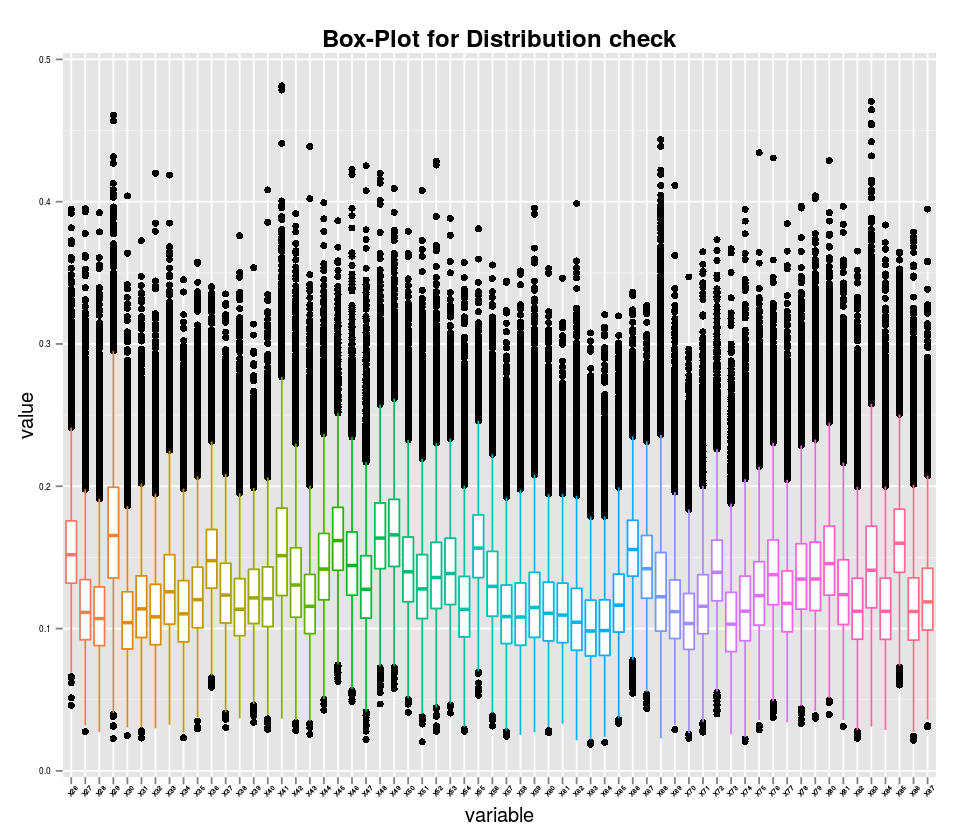

In [3]:
# before going ahead lets get a Box plot of data, getting a box plot is a good way to 
# check distribution and detect outlier

# creating copy to transform into a stacked dataframe. 
# [Reason to do: We cannot put all 62 columns of a dataframe when plotting and 
# need to use the data as a group by instead]

df_copy = df

# [Could have skipped the ID creation in this case but it just looks good to have one]
df_copy$id = rownames(df_copy)
df_copy.m = melt(df_copy, id.vars='id') 

# adjusting the plot frame
options(repr.plot.width = 8, repr.plot.height = 7)

# generating the plot
plt_box = ggplot(df_copy.m, aes(variable, y= value, colour = variable)) + 
            geom_boxplot() + theme(
                axis.text.x=element_text(angle = 45, color="black",size=3.8),
                axis.text.y=element_text(color="black",size=5),
                legend.position="none")

# adding title and aesthetics to title
plt_box + ggtitle("Box-Plot for Distribution check") + 
  theme(plot.title = element_text(lineheight=.8, face="bold"))

# deleting the copy and reshaped dataframe to free up the memory.
rm(df_copy)
rm(df_copy.m)

In [4]:
# skeness data for basic understanding and quick look!
skeness_check = data.frame(
    skewness = sapply(df, function(x) skewness(x)),
    mean_sensor = sapply(df, function(x) mean(x)),
    median_sensor = sapply(df, function(x) median(x))
)

# adding a severe_anomaly_check for severe anomalies [Purpose: indicate when average anomaly goes above 0.50]
skeness_check$severe_anomaly_check = skeness_check$mean_sensor < skeness_check$median_sensor
        
# Sorted (by mean anomaly)
cat('if severe_anomaly_check is `True` then there are some SEVERE ANOMALIES!')
skeness_check[order(skeness_check$mean_sensor, decreasing = T),]

if severe_anomaly_check is `True` then there are some SEVERE ANOMALIES!

,skewness,mean_sensor,median_sensor,severe_anomaly_check
X29,0.5079081,0.1694198,0.1653867,FALSE
X49,0.6200740,0.1691544,0.1658009,FALSE
X48,0.6553602,0.1671230,0.1635605,FALSE
X45,0.5728154,0.1647987,0.1618490,FALSE
X85,0.6578107,0.1635637,0.1599806,FALSE
X55,0.5082458,0.1591070,0.1565208,FALSE
X66,0.4575772,0.1576693,0.1555546,FALSE
X41,0.7229458,0.1568151,0.1512421,FALSE
X26,0.7618958,0.1557510,0.1519182,FALSE
X36,0.6597503,0.1508290,0.1477149,FALSE


In [5]:
# True here means severe anomaly!
table(skeness_check$severe_anomaly_check)


FALSE 
   62 

### Understanding on skewness: 

* if we have a higher anomaly it would increase the average anomaly and move the mean towards right (increase) or away from center value that would make the histogram look like left skewed. (which is not what we want)

# Section 3: Data Munging

* each bucket has a range of **0.02** and consists of records that are in each bucket for a given sensor.
* from the count of records in each bucket divided by # of rows in dataset [50000 in sample data] we get density of anomalous events.

In [6]:
# Generate a range and buckets to get frequency:  sequence criteria Given says 0 being good and 1 being most anomalous]
# options(repr.plot.width = 2.5, repr.plot.height = 2.5)
# a = hist(df$X26)
# brk = a$breaks[2]-a$breaks[1]
brackets = seq(0,1,by=0.02)
annomaly_buckets = paste(head(brackets,-1), brackets[-1], sep=" - ")

In [7]:
# bucketed df [create a new dataframe by mapping bucket for a value]
# this helps in creating with groups and frequency of events in a group and ultimately density!

bucketed_df = data.frame(sapply(df, function(x) cut(x, breaks=brackets, labels=annomaly_buckets)))
head(bucketed_df)

X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,...,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87
0.16 - 0.18,0.06 - 0.08,0.08 - 0.1,0.18 - 0.2,0.1 - 0.12,0.12 - 0.14,0.08 - 0.1,0.16 - 0.18,0.12 - 0.14,0.12 - 0.14,...,0.08 - 0.1,0.1 - 0.12,0.12 - 0.14,0.08 - 0.1,0.14 - 0.16,0.12 - 0.14,0.06 - 0.08,0.2 - 0.22,0.1 - 0.12,0.12 - 0.14
0.16 - 0.18,0.06 - 0.08,0.08 - 0.1,0.18 - 0.2,0.12 - 0.14,0.12 - 0.14,0.08 - 0.1,0.16 - 0.18,0.12 - 0.14,0.16 - 0.18,...,0.1 - 0.12,0.18 - 0.2,0.1 - 0.12,0.1 - 0.12,0.1 - 0.12,0.1 - 0.12,0.06 - 0.08,0.22 - 0.24,0.1 - 0.12,0.12 - 0.14
0.16 - 0.18,0.06 - 0.08,0.1 - 0.12,0.18 - 0.2,0.08 - 0.1,0.12 - 0.14,0.08 - 0.1,0.18 - 0.2,0.14 - 0.16,0.12 - 0.14,...,0.18 - 0.2,0.16 - 0.18,0.16 - 0.18,0.08 - 0.1,0.12 - 0.14,0.12 - 0.14,0.08 - 0.1,0.2 - 0.22,0.12 - 0.14,0.12 - 0.14
0.16 - 0.18,0.06 - 0.08,0.08 - 0.1,0.16 - 0.18,0.08 - 0.1,0.1 - 0.12,0.1 - 0.12,0.22 - 0.24,0.14 - 0.16,0.12 - 0.14,...,0.12 - 0.14,0.14 - 0.16,0.16 - 0.18,0.1 - 0.12,0.18 - 0.2,0.1 - 0.12,0.04 - 0.06,0.18 - 0.2,0.12 - 0.14,0.14 - 0.16
0.16 - 0.18,0.06 - 0.08,0.06 - 0.08,0.1 - 0.12,0.06 - 0.08,0.12 - 0.14,0.1 - 0.12,0.22 - 0.24,0.12 - 0.14,0.08 - 0.1,...,0.12 - 0.14,0.14 - 0.16,0.18 - 0.2,0.1 - 0.12,0.12 - 0.14,0.1 - 0.12,0.06 - 0.08,0.2 - 0.22,0.12 - 0.14,0.16 - 0.18
0.14 - 0.16,0.08 - 0.1,0.1 - 0.12,0.1 - 0.12,0.06 - 0.08,0.1 - 0.12,0.1 - 0.12,0.22 - 0.24,0.12 - 0.14,0.08 - 0.1,...,0.1 - 0.12,0.12 - 0.14,0.22 - 0.24,0.14 - 0.16,0.1 - 0.12,0.1 - 0.12,0.06 - 0.08,0.22 - 0.24,0.12 - 0.14,0.14 - 0.16


In [8]:
# transforming the data to compute count statistics
bucketed_df$id = rownames(bucketed_df)
#head(bucketed_df)
melt_bucketed_df = melt(bucketed_df, id.vars='id')
#head(melt_bucketed_df)
# Summarizing bucketed data to obtain frequency of event in a range for a given sensor
melt_bucketed_df= data.frame(table(melt_bucketed_df$variable, melt_bucketed_df$value))
head(melt_bucketed_df)

Var1,Var2,Freq
X26,0.04 - 0.06,2
X27,0.04 - 0.06,956
X28,0.04 - 0.06,1432
X29,0.04 - 0.06,49
X30,0.04 - 0.06,1546
X31,0.04 - 0.06,883


In [9]:
# converting back to normal frame so as to see how the frequency count looks wrt sensor
summary_bucketed_df = dcast(melt_bucketed_df, Var2 ~ Var1, value.var='Freq')
rownames(summary_bucketed_df) = summary_bucketed_df$Var2

# removing the bucket column from frame to keep it only numeric data
summary_bucketed_df = summary_bucketed_df[,-1]
head(summary_bucketed_df)

,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,...,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87
0.04 - 0.06,2,956,1432,49,1546,883,1388,525,1233,364,...,128,122,25,415,989,168,977,0,985,480
0.06 - 0.08,74,5286,6576,510,7548,5047,6315,2958,5882,2936,...,1143,1364,488,2646,5171,1620,5238,63,5447,3429
0.08 - 0.1,1105,11212,12209,1936,13040,10174,11944,7443,11123,8860,...,4928,5294,2863,7936,10858,4793,10963,744,10887,9185
0.1 - 0.12,5349,12799,12735,4696,12490,12697,12351,10828,12419,12630,...,9893,9762,7327,11639,12772,8409,12568,3420,12399,12692
0.12 - 0.14,10757,9375,8595,7065,8070,9844,8859,10515,9239,11263,...,11813,11298,11006,11262,9532,9540,9507,8561,9477,10683
0.14 - 0.16,12528,5359,4631,8425,4071,6036,4948,7995,5243,7295,...,9739,9353,10845,7521,5546,8706,5437,12221,5562,6871


In [10]:
# creating additional dataframe to get density of anomalies in a given range
density_bucketed_df = summary_bucketed_df/nrow(df)
head(density_bucketed_df)

,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,...,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87
0.04 - 0.06,0.00004,0.01912,0.02864,0.00098,0.03092,0.01766,0.02776,0.01050,0.02466,0.00728,...,0.00256,0.00244,0.00050,0.00830,0.01978,0.00336,0.01954,0.00000,0.01970,0.00960
0.06 - 0.08,0.00148,0.10572,0.13152,0.01020,0.15096,0.10094,0.12630,0.05916,0.11764,0.05872,...,0.02286,0.02728,0.00976,0.05292,0.10342,0.03240,0.10476,0.00126,0.10894,0.06858
0.08 - 0.1,0.02210,0.22424,0.24418,0.03872,0.26080,0.20348,0.23888,0.14886,0.22246,0.17720,...,0.09856,0.10588,0.05726,0.15872,0.21716,0.09586,0.21926,0.01488,0.21774,0.18370
0.1 - 0.12,0.10698,0.25598,0.25470,0.09392,0.24980,0.25394,0.24702,0.21656,0.24838,0.25260,...,0.19786,0.19524,0.14654,0.23278,0.25544,0.16818,0.25136,0.06840,0.24798,0.25384
0.12 - 0.14,0.21514,0.18750,0.17190,0.14130,0.16140,0.19688,0.17718,0.21030,0.18478,0.22526,...,0.23626,0.22596,0.22012,0.22524,0.19064,0.19080,0.19014,0.17122,0.18954,0.21366
0.14 - 0.16,0.25056,0.10718,0.09262,0.16850,0.08142,0.12072,0.09896,0.15990,0.10486,0.14590,...,0.19478,0.18706,0.21690,0.15042,0.11092,0.17412,0.10874,0.24442,0.11124,0.13742


In [11]:
# transforming data to be able to access data in all columns when plotting in next step
density_bucketed_df$id = rownames(density_bucketed_df)
melted_d_b_df = melt(density_bucketed_df, id.vars='id')
head(melted_d_b_df)

id,variable,value
0.04 - 0.06,X26,0.00004
0.06 - 0.08,X26,0.00148
0.08 - 0.1,X26,0.02210
0.1 - 0.12,X26,0.10698
0.12 - 0.14,X26,0.21514
0.14 - 0.16,X26,0.25056


# Section 4: Anomaly Density Plot

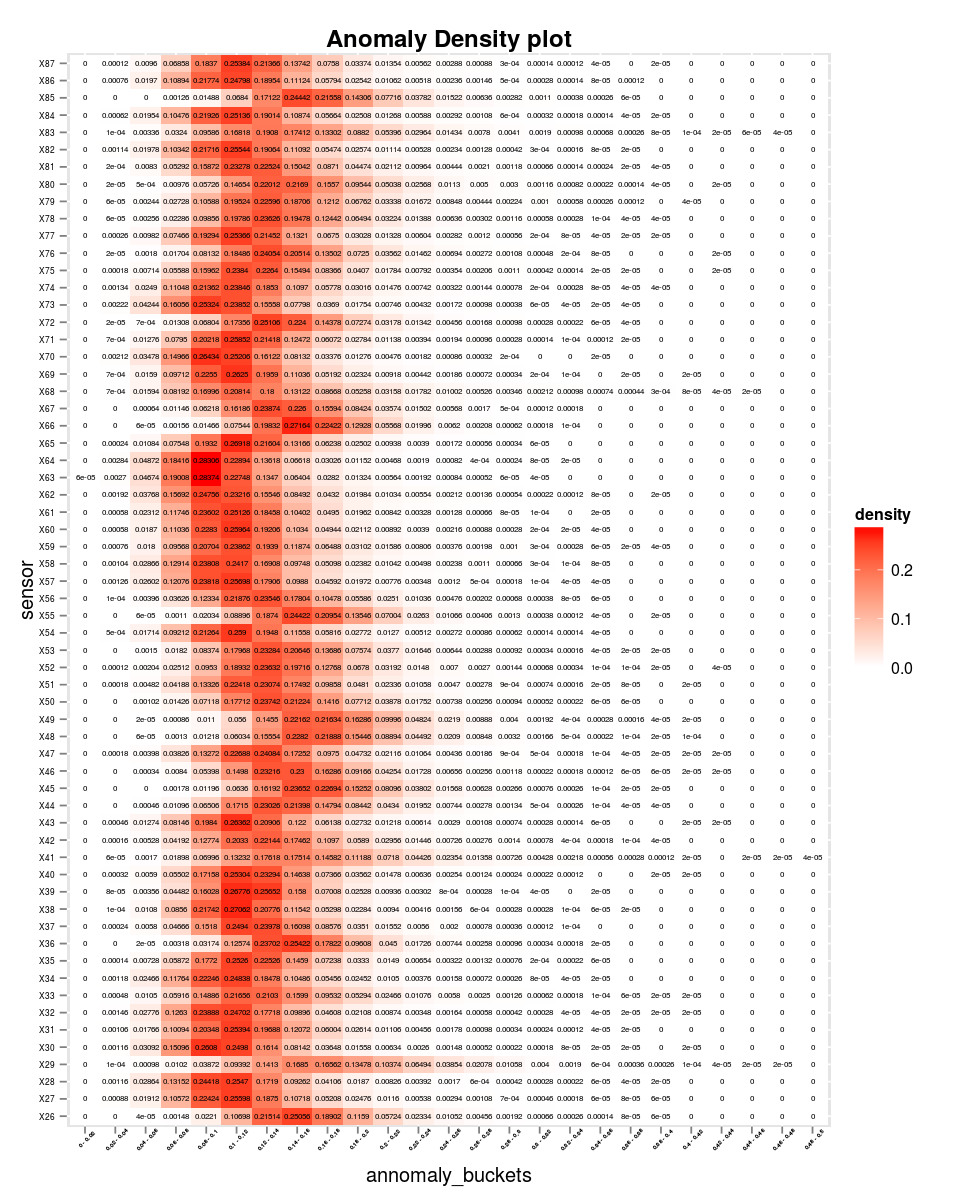

In [12]:
# renaming column names
colnames(melted_d_b_df) = c('annomaly_buckets', 'sensor', 'density')

# setting plot dimension in Jupyter Notebook
options(repr.plot.width = 8, repr.plot.height = 10)

# generating the density plot
plt = ggplot(melted_d_b_df, aes(annomaly_buckets, sensor)) +
  geom_tile(aes(fill = density)) + 
  geom_text(aes(label = density), size = 1.7) +
  scale_fill_gradient(low = "white", high = "red") + 
  theme(axis.text.x=element_text(angle = 45, color="black",size=3.5),
        axis.text.y=element_text(color="black",size=5))

# adding title and aesthetics to title
plt + ggtitle("Anomaly Density plot") + 
  theme(plot.title = element_text(lineheight=.8, face="bold"))

# Section 5: Interpretation and basic result validation

1. The anomaly values are mostly condensed in **"0.8-0.16"** range.
2. Theer are still some anomalies in the higher segment which is not desired from the point on manufacturing **(X41 @ 0.48-0.5 bucket)**.
3. The highest bucket of anomaly level that has some records is **"0.48-0.5"** but has event from only 1 sensors. [could be a point of further investigation]

In [13]:
# Further Validating the results from the chart:
# expected to be something in range 0.48-0.5 and from sensor X41

maxes_out = data.frame(max_value = sapply(df, function(x) max(x)))
mins_out = data.frame(max_value = sapply(df, function(x) min(x)))
cat(rownames(maxes_out)[apply(maxes_out, 2, which.max)], 
    'is the column with maximum value as: ',max(as.matrix(df)), '\n\n')
    
cat(rownames(mins_out)[apply(mins_out, 2, which.min)], 
    'is the column with minimum value as: ',min(as.matrix(df)), '\n\n')

cat('Now in the density plot we see only one value for these columns and looks like to be correct!') 

X41 is the column with maximum value as:  0.4813561 

X63 is the column with minimum value as:  0.0187171 

Now in the density plot we see only one value for these columns and looks like to be correct!